In [2538]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch import nn

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2539]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


# Dataset Setup

In [2540]:
# load dataset
height = 4
width = 4
depth = 24

all_hists = []
labels = []
binary_labels = []
zero_hists = []

zone_to_label = {
    0: [0, 0, 0],
    1: [1, 0, 0],
    2: [0, 1, 0],
    3: [0, 0, 1],
    4: [1, 1, 0],
    5: [1, 0, 1],
    6: [0, 1, 1],
    7: [1, 1, 1],
}

zone_to_label_binary = {
    0: [0],
    1: [1],
    2: [1],
    3: [1],
    4: [1],
    5: [1],
    6: [1],
    7: [1],
}

In [2541]:
for i in range(4):
    hists = np.load(f'datasets/display-box-12/histograms_{i}.npy')

    hists = hists.reshape(-1, height, width, depth)
    # move depth to the front
    hists = np.moveaxis(hists, -1, 1)

    # look at first 10 bins
    # data = np.array(hists[:, :10, :, :])
    # data = np.array(hists[:, :, :, :])
    data = hists

    # Compute the mean and standard deviation for each position (10, 4, 4) across all samples
    mean = data.mean(axis=0)  # Shape: (10, 4, 4)
    std = data.std(axis=0)    # Shape: (10, 4, 4)

    # Compute the threshold for values being within 3 standard deviations
    lower_bound = mean - 3 * std
    upper_bound = mean + 3 * std

    # Only consider the first n values along the 10-axis (shape: n x 4 x 4)
    n = 4
    data_to_check = data[:, :n, :, :]  # Shape: (4000, n, 4, 4)
    lower_bound_check = lower_bound[:n, :, :]  # Shape: (n, 4, 4)
    upper_bound_check = upper_bound[:n, :, :]  # Shape: (n, 4, 4)

    # Identify samples where all values in the first 3 indices along the 10-axis are within bounds
    valid_mask = np.all((data_to_check >= lower_bound_check) & (data_to_check <= upper_bound_check), axis=(1, 2, 3))

    # Apply the mask to filter the samples
    filtered_data = data[valid_mask]

    hists = filtered_data

    # sliding window mean smoothing
    # Compute the sliding window mean
    k = 5
    sliding_mean = np.array([
        hists[j - k + 1 : j + 1].mean(axis=0)  # Mean of the last k elements
        for j in range(k - 1, len(hists))
    ])
    
    hists = sliding_mean

    # generate more data by adding gaussian noise with std of the actual data std (changes for bin/pixel)
    # std = hists.std(axis=0)
    # hists = np.repeat(hists, 5, axis=0)
    # hists += np.random.normal(0, std, hists.shape)

    if i == 0:
        zero_hists.append(hists)        
    
    all_hists.append(hists)
    labels += [zone_to_label[i]] * len(hists)
    binary_labels += [zone_to_label_binary[i]] * len(hists)

In [2542]:
zero_hists = np.concatenate(zero_hists, axis=0)
all_hists = np.concatenate(all_hists, axis=0)
labels = np.array(labels)
binary_labels = np.array(binary_labels)

In [2543]:
start_bin = 4
end_bin = 16

In [2544]:
# crop first bounce bins (first bounce in first 2 bins)
# crop bins that are too far and noisy
all_hists = all_hists[:, start_bin:end_bin, :, :]
zero_hists = zero_hists[:, start_bin:end_bin, :, :]

In [2545]:
all_hists = torch.tensor(all_hists, dtype=torch.float32)
zero_hists = torch.tensor(zero_hists, dtype=torch.float32)

In [2546]:
# pick 20 random zero hists to act as the zero mean
num_samples_to_mean = 20

random_zero_mean = torch.empty((all_hists.shape[0], all_hists.shape[1], height, width))

for i in range(all_hists.shape[0]):
    indices = torch.randint(0, zero_hists.shape[0], (num_samples_to_mean,), generator=torch.Generator().manual_seed(1))
    random_zero_mean[i] = zero_hists[indices].mean(dim=0)

In [2547]:
all_hists_rel = all_hists - random_zero_mean

In [2548]:
zero_mask = np.all(labels == np.array([0, 0, 0]), axis=1)
location_mask = ~zero_mask

In [2549]:
all_hists_rel_location = all_hists_rel[location_mask]
labels_location = labels[location_mask]

In [2550]:
# Convert numpy arrays to PyTorch tensors
all_hists_tensor = all_hists_rel_location
# all_hists_tensor = torch.tensor(all_hists_rel, dtype=torch.float32)
labels_tensor = torch.tensor(labels_location, dtype=torch.float32)
all_hists_binary_tensor = all_hists_rel
binary_labels_tensor = torch.tensor(binary_labels, dtype=torch.float32)

# epsilon = 0.1  # Smoothing factor
# labels_tensor = (1 - epsilon) * labels_tensor + epsilon * 0.5  # Smooth towards uniform distribution

# Create a TensorDataset
dataset = TensorDataset(all_hists_tensor, labels_tensor)
binary_dataset = TensorDataset(all_hists_binary_tensor, binary_labels_tensor)

batch_size = 32

# Create DataLoaders for each set
test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
binary_test_loader = DataLoader(binary_dataset, batch_size=batch_size, shuffle=False)

# Location Model Setup

In [2551]:
class CounterCNN(nn.Module):
    def __init__(self):
        super(CounterCNN, self).__init__()
        # self.conv1 = nn.Conv2d(in_channels=(end_bin - start_bin), out_channels=16, kernel_size=3, padding=1)
        # self.batchnorm1 = nn.BatchNorm2d(16)
        # self.conv2 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, padding=1)
        # self.batchnorm2 = nn.BatchNorm2d(64)

        out_channels = 4
        self.conv3d = nn.Conv3d(in_channels=1, out_channels=out_channels, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.batchnorm3d = nn.BatchNorm3d(out_channels)

        self.fc1 = nn.Linear(out_channels * (end_bin - start_bin) * height * width, 128)

        # self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc1_bn = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 3)  # Assuming 10 classes for the labels
        self.relu = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(p=0.7)

    def forward(self, x):
        # # print(f'x shape at start: {x.shape}')
        # x = self.relu(self.conv1(x))
        # # print(f'x shape after conv1: {x.shape}')
        # x = self.batchnorm1(x)
        # # x = self.pool(x)
        # # print(f'x shape after pool1: {x.shape}')
        # x = self.relu(self.conv2(x))
        # # print(f'x shape after conv2: {x.shape}')
        # x = self.batchnorm2(x)

        x = self.relu(self.conv3d(x.unsqueeze(1)))
        x = self.batchnorm3d(x)

        # x = self.pool(x)
        # print(f'x shape after pool2: {x.shape}')
        x = torch.flatten(x, 1)
        # print(f'x shape after flatten: {x.shape}')
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc1_bn(x)
        x = self.fc2(x)
        return x

In [2552]:
loss_fn = nn.BCEWithLogitsLoss()

In [2553]:
def test_counter(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            # y = y.unsqueeze_(1)
            # print(X.shape)
            # print(y.shape)
            test_loss += loss_fn(pred, y).item()
            # final_pred = torch.round(torch.clamp(pred, min=0, max=1))
            final_pred = torch.round(torch.sigmoid(pred))
            
            # print(final_pred.shape)
            # print("true")
            # print(y)
            # print("pred")
            # print(final_pred)
            # print("diff")
            # print(final_pred - y)
            exact_match = torch.all(final_pred == torch.round(y), dim=1)
            correct += torch.sum(exact_match).item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

In [2554]:
model_save_path = 'models/display-box-16-rolling-means-noise-location.mdl'

In [2555]:
model = CounterCNN().to(device)
model.load_state_dict(torch.load(model_save_path))

/var/folders/3c/gwjrml9d76v_zwbyb2x6yc0r0000gn/T/ipykernel_65523/2522857457.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_p

<All keys matched successfully>

## Testing Location Model

In [2556]:
# Out of sample test
model.eval()
# test(test_loader, model, loss_fn)
test_counter(test_loader, model, loss_fn)

Test Error: 
 Accuracy: 60.6%, Avg loss: 0.370272 



(0.3702719581431185, 0.605994944023113)

In [2557]:
# Set the model to evaluation mode
model.eval()

# Initialize a list to store predictions
predictions = []

# Disable gradient calculation
with torch.no_grad():
    for X, _ in test_loader:
        X = X.to(device)
        output = model(X)
        # predicted_classes = output.argmax(dim=1)
        # predictions.extend(predicted_classes.cpu().numpy())
        # predicted_zones = torch.round(torch.clamp(output, min=0, max=1))
        predicted_zones = torch.round(torch.sigmoid(output))
        predictions.extend(predicted_zones.cpu().numpy())

# Convert predictions to a numpy array
y_preds = np.array(predictions)
print(y_preds)

y_test = np.array([y for _, y in dataset])

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


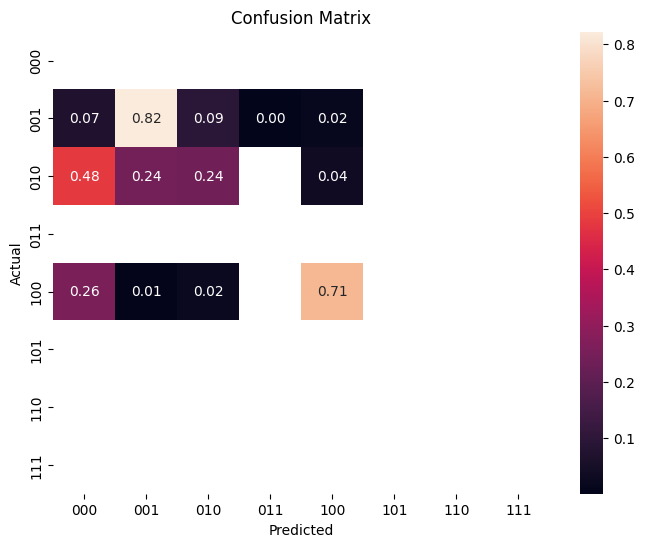

In [2558]:
categories = ["000", "001", "010", "011", "100", "101", "110", "111"]

y_test = np.array([y for _, y in dataset]).astype(int)
y_preds = np.array([p for p in predictions]).astype(int)

y_test = [''.join(map(str, label)) for label in y_test]
y_preds = [''.join(map(str, label)) for label in y_preds]


# Compute confusion matrix with all possible labels
conf_matrix = confusion_matrix(y_test, y_preds, labels=categories)
row_sums = conf_matrix.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1
conf_matrix_normalized = conf_matrix.astype('float') / row_sums
conf_matrix_normalized[conf_matrix == 0] = np.nan

# Plot the heatmap
plt.figure(figsize=(8,6), dpi=100)
ax = sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", mask=np.isnan(conf_matrix_normalized))

# Set tick labels
ax.set_xticks(np.arange(len(categories)) + 0.5)
ax.set_yticks(np.arange(len(categories)) + 0.5)
ax.set_xticklabels(categories)
ax.set_yticklabels(categories)

# Labels and title
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

plt.show()


# Binary Model Setup

In [2559]:
class CounterCNN(nn.Module):
    def __init__(self):
        super(CounterCNN, self).__init__()
        # self.conv1 = nn.Conv2d(in_channels=(end_bin - start_bin), out_channels=16, kernel_size=3, padding=1)
        # self.batchnorm1 = nn.BatchNorm2d(16)
        # self.conv2 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, padding=1)
        # self.batchnorm2 = nn.BatchNorm2d(64)

        out_channels = 4
        self.conv3d = nn.Conv3d(in_channels=1, out_channels=out_channels, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.batchnorm3d = nn.BatchNorm3d(out_channels)

        self.fc1 = nn.Linear(out_channels * (end_bin - start_bin) * height * width, 128)

        # self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc1_bn = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 1)  # Assuming 10 classes for the labels
        self.relu = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(p=0.7)

    def forward(self, x):
        # # print(f'x shape at start: {x.shape}')
        # x = self.relu(self.conv1(x))
        # # print(f'x shape after conv1: {x.shape}')
        # x = self.batchnorm1(x)
        # # x = self.pool(x)
        # # print(f'x shape after pool1: {x.shape}')
        # x = self.relu(self.conv2(x))
        # # print(f'x shape after conv2: {x.shape}')
        # x = self.batchnorm2(x)

        x = self.relu(self.conv3d(x.unsqueeze(1)))
        x = self.batchnorm3d(x)

        # x = self.pool(x)
        # print(f'x shape after pool2: {x.shape}')
        x = torch.flatten(x, 1)
        # print(f'x shape after flatten: {x.shape}')
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc1_bn(x)
        x = self.fc2(x)
        return x

In [2560]:
binary_model_save_path = 'models/display-box-18-rolling-means-noise-binary.mdl'

In [2561]:
binary_model = CounterCNN().to(device)
binary_model.load_state_dict(torch.load(binary_model_save_path))

/var/folders/3c/gwjrml9d76v_zwbyb2x6yc0r0000gn/T/ipykernel_65523/3807689864.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  binary_model.load_state_dict(torch.load(binar

<All keys matched successfully>

## Testing Binary Model

In [2562]:
# Out of sample test
binary_model.eval()
# test(test_loader, model, loss_fn)
test_counter(binary_test_loader, binary_model, loss_fn)

Test Error: 
 Accuracy: 75.8%, Avg loss: 0.414124 



(0.4141244306457906, 0.7576571735626008)

In [2563]:
# Set the model to evaluation mode
binary_model.eval()

# Initialize a list to store predictions
predictions = []

# Disable gradient calculation
with torch.no_grad():
    for X, _ in binary_test_loader:
        X = X.to(device)
        output = binary_model(X)
        # predicted_classes = output.argmax(dim=1)
        # predictions.extend(predicted_classes.cpu().numpy())
        # predicted_zones = torch.round(torch.clamp(output, min=0, max=1))
        predicted_zones = torch.round(torch.sigmoid(output))
        predictions.extend(predicted_zones.cpu().numpy())

# Convert predictions to a numpy array
y_preds = np.array(predictions)
print(y_preds)

y_test = np.array([y for _, y in binary_dataset])

[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


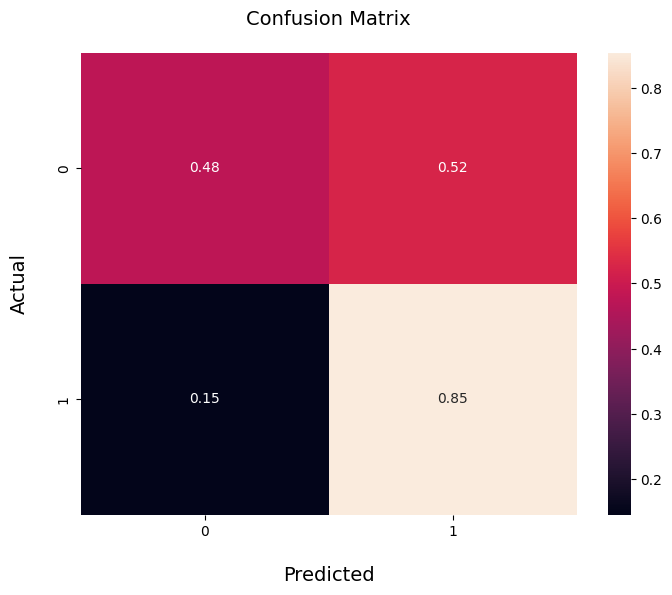

In [2564]:
y_test = np.array([y[0] for _, y in binary_dataset]).astype(int)
y_preds = np.array([p[0] for p in predictions]).astype(int)
conf_matrix = confusion_matrix(y_test, y_preds)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Change figure size and increase dpi for better resolution
plt.figure(figsize=(8,6), dpi=100)
# Scale up the size of all text
 
# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format   
# annot = True: show the numbers in each heatmap cell
# fmt = 'd': show numbers as integers. 
ax = sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', )
 
# set x-axis label and ticks. 
ax.set_xlabel("Predicted", fontsize=14, labelpad=20)
tick_labels = [0, 1]
ax.xaxis.set_ticklabels(tick_labels)
 
# set y-axis label and ticks
ax.set_ylabel("Actual", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(tick_labels)
 
# set plot title
ax.set_title("Confusion Matrix", fontsize=14, pad=20)
 
plt.show()